# Bee or Wasp Classification

### 6310401165 วิศรุต หอมแก่นจันทร์

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image  import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as implt
import seaborn as sns
import cv2 as cv
import random
import PIL
from PIL import Image
import tkinter as tk
from tkinter.filedialog import askopenfilename
from IPython.display import display, HTML, Image
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing import image
from sklearn.metrics import roc_curve, auc

## Data set

In [2]:
data = "datasets"
classes = sorted(os.listdir(data))
classes

['bee', 'wasp']

In [3]:
classes_info = {}
for name in classes:
    classes_info[name] = len(os.listdir(data + f'/{name}'))
print(classes_info)

{'bee': 3183, 'wasp': 4943}


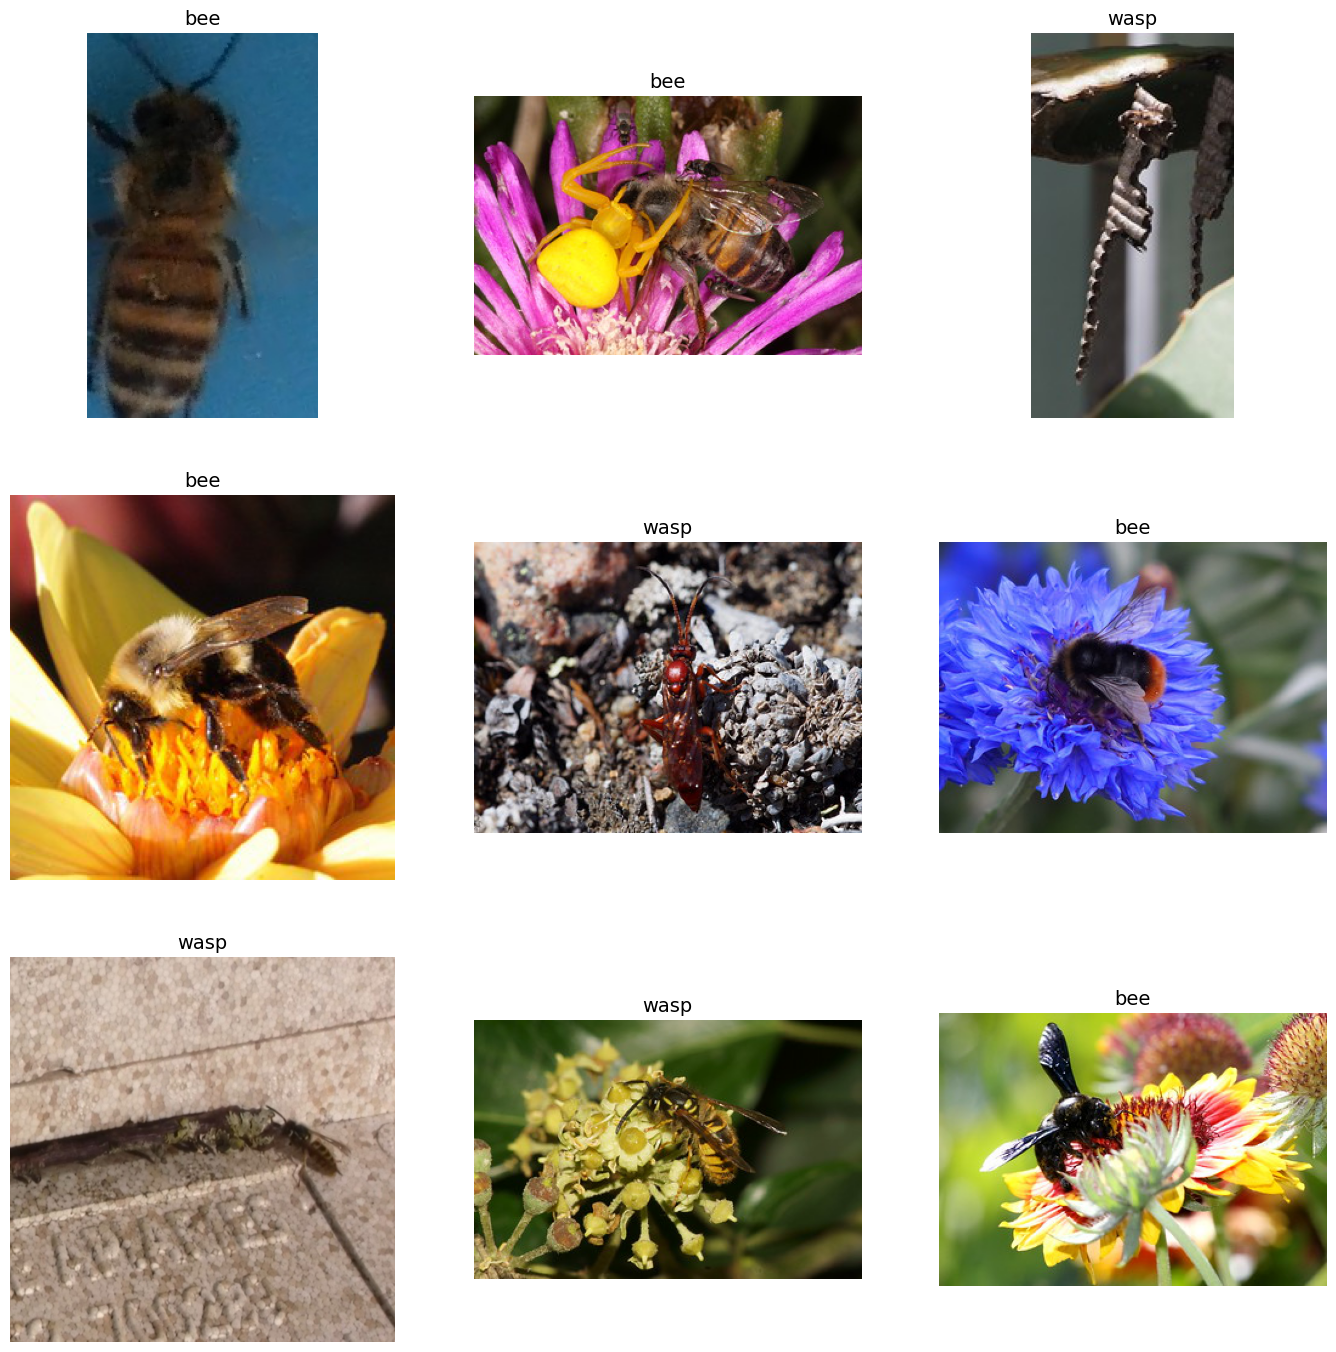

In [4]:
# visualize the data
W = 3
H = 3
fig, axes = plt.subplots(W, H, figsize = (17,17))

axes = axes.ravel() # flaten the matrix into array

# Select a random number from 0 to n_training/ images will be selected randomly
for i in np.arange(0, W * H): 
    
    # Select a class randomly
    label = random.choice(os.listdir(data))
    class_dir = os.path.join(data,label)
    
    # Select a random image
    image = random.choice(os.listdir(class_dir))
    
    # read and display an image with the selected index    
    img = plt.imread(os.path.join(class_dir,image))
    axes[i].imshow( img )
    axes[i].set_title(label, fontsize = 14) # the label
    axes[i].axis('off')

## Processing Dataset

In [5]:
bee_dataset = sorted(os.listdir(data +'/bee'))
wasp_dataset = sorted(os.listdir(data +'/wasp'))

In [6]:
bee_insect = [] 
wasp_insect = []
label = []

for i in bee_dataset:
    if os.path.isfile(data+'/bee/'+ i):
        insect = PIL.Image.open(data+'/bee/'+ i).convert('L')
        insect = insect.resize((50,50), PIL.Image.Resampling.LANCZOS) # Resize the image to 50x50 pixels using the Lanczos resampling algorithm
        insect = np.asarray(insect)/255.0 #normalizing images
        bee_insect.append(insect)  
        label.append(0)
        
for i in wasp_dataset:
    if os.path.isfile(data +'/wasp/'+ i):
        insect = PIL.Image.open(data +'/wasp/'+ i).convert('L')         
        insect = insect.resize((50,50), PIL.Image.Resampling.LANCZOS) 
        insect = np.asarray(insect)/255.0 
        wasp_insect.append(insect)  
        label.append(1)

In [7]:
x = np.concatenate((wasp_insect,bee_insect),axis=0)
y = np.array(label)
y = y.reshape(y.shape[0],1)

In [8]:
print("wasp_insect:",np.shape(wasp_insect) , "bee_insect:",np.shape(bee_insect))
print("dataset:",np.shape(x), "train_values:",np.shape(y))

wasp_insect: (4943, 50, 50) bee_insect: (3183, 50, 50)
dataset: (8126, 50, 50) train_values: (8126, 1)


In [9]:
x = x.reshape(x.shape[0],x.shape[1]*x.shape[2])

In [10]:
print("images:",np.shape(x), "labels:",np.shape(y))

images: (8126, 2500) labels: (8126, 1)


## Train / Test Split

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=50)
number_of_train = x_train.shape[0]
number_of_test = x_test.shape[0]

print("train number:",number_of_train, "test number:",number_of_test)

train number: 6500 test number: 1626


In [13]:
print("x train: ",x_train.shape)
print("y train: ",y_train.shape)
print("x test: ",x_test.shape)
print("y test: ",y_test.shape)

x train:  (6500, 2500)
y train:  (6500, 1)
x test:  (1626, 2500)
y test:  (1626, 1)


## Logistic Regression

In [14]:
class LogisticRegression:
    def __init__(self, learning_rate=0.001, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None
        self.train_losses = []
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros((1, num_features))  # Reshape self.weights to have the same shape as dw.T
        self.bias = 0
    
        # Reshape y to match the shape of predictions
        y = y.reshape(-1, 1)

        # Gradient descent
        for epoch in range(self.num_iterations):
            linear_model = np.dot(X, self.weights.T) + self.bias
            predictions = self.sigmoid(linear_model)

            train_loss = -np.mean(y_train * np.log(predictions) + (1 - y_train) * np.log(1 - predictions))
            self.train_losses.append(train_loss)
            
            # Gradient calculation
            dw = (1 / num_samples) * np.dot(X.T, (predictions - y))
            db = (1 / num_samples) * np.sum(predictions - y)

            # Update weights and bias
            self.weights -= self.learning_rate * dw.T
            self.bias -= self.learning_rate * db
    
    def predict(self, X):
        linear_model = np.dot(X, self.weights.T) + self.bias
        predictions = self.sigmoid(linear_model)
        # Round predictions to 0 or 1
        return [1 if pred > 0.5 else 0 for pred in predictions]

    def plot_roc_curve(self, X_test, y_test):
        probs = self.predict(X_test)
        fpr, tpr, _ = roc_curve(y_test, probs)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

In [15]:
model = LogisticRegression(learning_rate=0.001,num_iterations=1000)
model.fit(x_train,y_train)

In [16]:
predictions = model.predict(x_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.6285362853628537


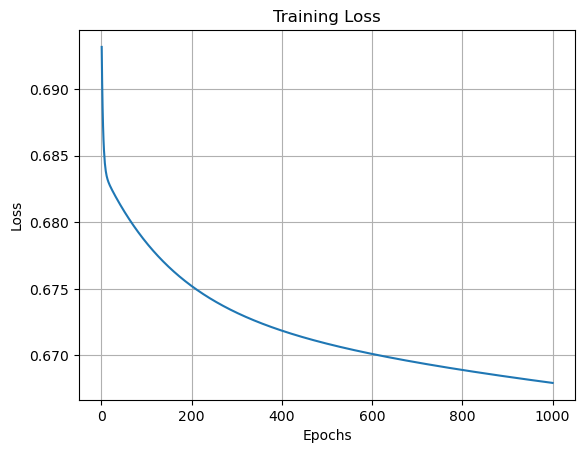

Accuracy: 0.6285362853628537


In [17]:
epochs = range(1, model.num_iterations + 1)
plt.plot(epochs, model.train_losses,)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()
print("Accuracy:", accuracy)

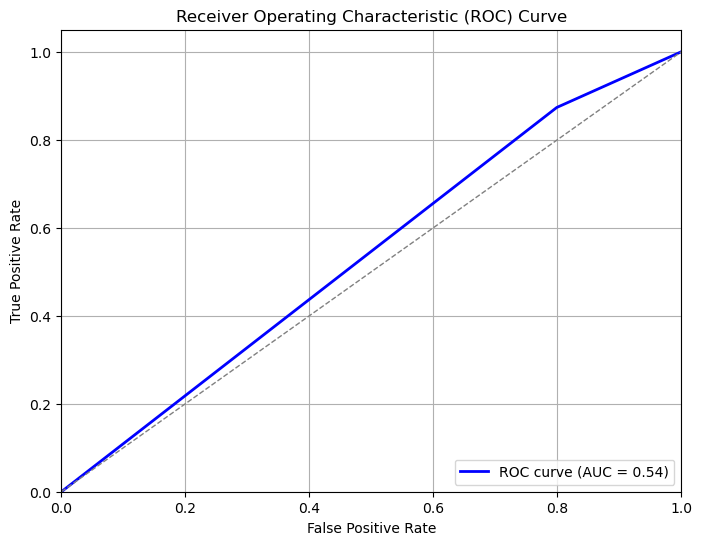

In [19]:
model.plot_roc_curve(x_test, y_test)

# User Input

In [20]:
filetypes = (
        ('Image files', '*.jpg'),
        ('Image files', '*.jpeg'),
        ('Image files', '*.png'),
)

root = tk.Tk()
root.attributes('-topmost',True)
root.iconify()
    
img_path = askopenfilename(title='Choose your insect picture',
                            filetypes=filetypes,
                            parent=root)

root.destroy()

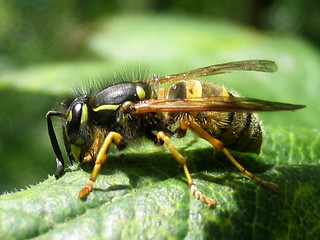

In [21]:
display(Image(img_path))

In [22]:
def preprocess_image(image_path):
    img = PIL.Image.open(image_path).convert('L')
    img = img.resize((50, 50),PIL.Image.Resampling.LANCZOS)
    img = np.asarray(img)/255.0
    return img

In [23]:
input = []
image = preprocess_image(img_path)
input.append(image)

x = np.concatenate((input),axis=0)
x = x.reshape(1,x.shape[0]*x.shape[1])

In [24]:
predicted_class = model.predict(x)
print('This is {}.'.format(classes[predicted_class[0]]))

This is wasp.
